# Chapter 7: Ulysses' Compass - Exercises

**7E1** State the three motivating criteria that define information entropy. Try to express each in your own words.

Answer:

1. The measure of uncertainty should be **continuous**. This means that small changes would not cause big differences in uncertainty.

2. The measure of uncertainty should **increase with the number of events** happening. If we are measuring uncertainty for something complex, it should be more uncertain.

3. The measure of uncertainty should be **additive**. 

**7E2** Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70% of the time. What is the entropy of this coin?

In [8]:
import numpy as np

coin = np.array([0.70, 0.30])
-np.sum(coin * np.log2(coin))

0.8812908992306927

**7E3** Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

In [11]:
die = np.array([0.2, 0.25, 0.25, 0.3])
-np.sum(die * np.log2(die))

1.9854752972273344

**7E4** Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?

Answer: 

The entropy is not valid for this probability distribution. And it makes sense because it means that we can be certain that something that never shows a "4" will never be able to have a distribution with a "4" showing 1 or more times.

**7M1** Write down and compare the definitions of AIC and WAIC. Which of these criteria is most general? Which assumptions are required to transform the more general criterion into a less general one?

Answer:

AIC:
$$\text{AIC} = D_{train} + 2p = -2\text{lppd} + 2p$$

WAIC:
$$\text{WAIC}(y,\Theta) = -2(\text{lppd} - \sum_i \text{var}_{\theta} \text{log}p(y_i|\theta))$$

AIC uses parameters as a penalty to the information criterion, and WAIC uses the sum of the variation of the individual obervations. WAIC is more general and is less constrained than the AIC.

**7M2** Explain the difference between model selection and model comparison. What information is lost under model selection?

Answer:

Model selection is using information from measures such as the ones from Information Criteria to choose one model over another. Model comparison is using the differences in measures between all models to get an understanding of improvement over all the model's distribution.

**7M3** When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure.

Answer:

Information criteria increases with sample size and has different values depending on the observations. This means that the comparison won't be correct if we use different samples between the models.

**7M4** What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior becomes more concentrated? Why? Perform some experiments, if you are not sure.

Answer:

The narrower prior makes a narrower posterior and therefore the penalty term in WAIC will be smaller. Therefore the effective number of parameters will also be smaller.

**7M5** Provide an informal explanation of why informative priors reduce overfitting.

Answer:

Science knowledge is superior to modeling. If we can use informative priors, we give less space to the model to make mistakes.

**7M6** Provide an informal explanation of why overly informative priors result in underfitting.

If we have a very strict prior, than the model can adapt the posterior very close to the prior and won't be able to use the other observations to prepare itself for unseen data.

**7H1** In 2007, The Wall Street Journal published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in (reconstructed at right), seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in data(Laffer). Consider models that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a straight-line model to any curved models you like. What do you conclude about the relationship between tax rate and tax revenue?

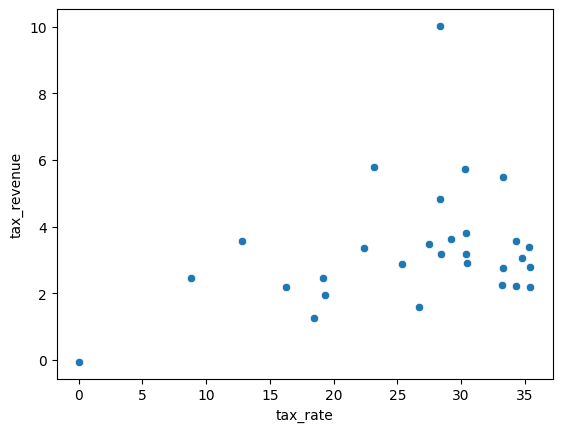

In [19]:
from rethinking import DATA_PATH, standardize
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Laffer = pd.read_csv(DATA_PATH.joinpath('Laffer.csv'), sep=';')
sns.scatterplot(x='tax_rate', y='tax_revenue', data=Laffer);

# standardise the data
Laffer["s_taxRate"] = standardize(Laffer['tax_rate'])
Laffer["s_taxRevenue"] = standardize(Laffer['tax_revenue'])

In [118]:
import pymc as pm
from rethinking import quap
from scipy import stats
from scipy.special import logsumexp

def waic(x_values, y_values, n_pols, post_, varss_):

    matrix = (
        np.tile(x_values, (n_pols, 1)) 
        ** np.arange(1, n_pols+1).reshape(-1, 1)
    )

    var_names = (
        [varss_[0].name] 
        + [f'{varss_[1]}{i}' for i in range(n_pols)]
        + [varss_[-1].name]
    )

    post_data = pd.DataFrame(post_.rvs(10_000), columns=var_names)

    B = post_data.filter(regex='b').values.T
    mu = (post_data[['a']].values + np.dot(B.T, matrix)).T
    sig = post_data[['sigma']].values.T


    logprob = stats.norm.logpdf(
        y_values.reshape(-1, 1),
        loc=mu,
        scale=sig
    )

    n_cases = len(x_values)
    lppd = logsumexp(logprob, axis=1) - np.log(10_000)
    pWAIC = logprob.var(axis=1)
    waic_val = -2*(lppd.sum() - pWAIC.sum())
    
    waic_vec = -2 * (lppd - pWAIC)
    stderr = (n_cases * waic_vec.var())**0.5
    return waic_val, pWAIC, stderr


def model_laffer(x_values, y_values, n_pols):
    tax_matrix = (
        np.tile(x_values, (n_pols, 1)) 
        ** np.arange(1, n_pols+1).reshape(-1, 1)
    )


    with pm.Model() as model:
        a = pm.Normal('a', 0, 0.2)
        b = pm.Normal('b', 0, 0.5, shape=tax_matrix.shape[0])
        sigma = pm.Lognormal('sigma', 0, 1)
        mu = pm.Deterministic('mu', a + pm.math.dot(b, tax_matrix))
        rev = pm.Normal('rev', mu, sigma, observed=y_values)
        post, vars_ = quap(model)
    
    return post, vars_

In [120]:
n_polynomials = np.arange(1, 5)
taxRate = Laffer['s_taxRate'].values
taxRevenue = Laffer['s_taxRevenue'].values

for pol in n_polynomials:
    post, vars_ = model_laffer(taxRate, taxRevenue, pol)
    waic_, pwaic, stderr_ = waic(taxRate, taxRevenue, pol, post, vars_)
    print(f'N_pol: {pol}, Waic: {waic_} +- {stderr_}, penalty: {pwaic.sum()}')


N_pol: 1, Waic: 92.34323935601236 +- 25.363160568026654, penalty: 7.869117703988209



N_pol: 2, Waic: 94.28999330127895 +- 29.634523375867357, penalty: 9.945490903490281



N_pol: 3, Waic: 96.23438587389074 +- 30.550132628624024, penalty: 10.966577602117185



N_pol: 4, Waic: 97.13899657102155 +- 32.123097579492786, penalty: 11.898309366015337


There is no substantial difference between the modles, and the penalty seems to increase with the order of the polynomials. We should be careful with making assumptions about this.